In [65]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [66]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03 #term used for regularization in order to prevent overfitting
TrainingPercent = 80 #Percentage of data considered for training the model
ValidationPercent = 10 #Percentage of data considered for validation
TestPercent = 10 #Percentage of data considered for testing
M = [1,10,50,100,2] # number of radial basis functions.
PHI = [] # this is the design matrix
IsSynthetic = False

In [67]:
# This is used to generate raw data(datamatrix)
# generate datasets
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

# this method is used to generate data from querylevelnorm.csv
# data matrix will be of the dimensions 41 * 69623
# 41 is the number of features
# 69623 is the total number of rows in the dataset
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)# we are deleting this 5 features because the values are 0
    dataMatrix = np.transpose(dataMatrix)     
    print ("Data Matrix Generated..")
    print(dataMatrix.shape)
    return dataMatrix
# This is taking 80% of the target values from the entire target 
def GenerateTrainingTarget (rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t  
# This method is used to specify and seperate 80% of the data is for training data
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2
# This method is used to specify and seperate 10% of the data is for validation data.
# The same method is called for testing data as well because it is the same 10% again.
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix
# This method is for the file QueryLevelNormt.csv
# prepares the target values for validation dataset
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# this function is used to generate the bigsigma matrix which is used in the normal distribution formula.
# Big sigma is the variance matrix. 
# We assume all varainces are equal for a particular feature.
# Hence the variance matrix will be of the shape 41 * 41.
# it is not 46 * 46 because 5 features are being deleted.
# we ll have elements only in the diagnol of the matrix.
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma
# The gaussian distribution function is 0.5(X-Mu)* BigSigInv* (x-Mu)transpose.
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow) # This subtracts X- Mu and stores in R
    T = np.dot(BigSigInv,np.transpose(R))  # Multiplies R transpose and BigSigInv and stores in T
    L = np.dot(R,T) # Multiplies T and R and returns L
    return L
# This functions is the gaussian distribution formula.
# This is used to return each PHI and not the PHI matrix.
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x
# This method is used to get the Phi matrix which is the design matrix.
# Phi matrix is the result of the radial basis function.
# We are using 10 radial basis function and hence dimension of phi matrix will be 10 * number of data
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01 ))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma) # We calculated BigSigma only. But we needed Inverse of Big Sigma acc. to the formula
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)#Every PHI calculated is stored in a Matrix called PHI
    #print ("PHI Generated..")
    return PHI

# Lamba is a regularization term used to prevent overfitting
# This method is used to get the closed form W* 
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

# This is for the regression formula y = phi *w transpose
# returns our predicted value
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y
# This is used to find our accuracy and Erms based on target and the predicted value.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [68]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

C:\Users\tceve\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 'U' mode is deprecated
  """
C:\Users\tceve\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 'U' mode is deprecated


Data Matrix Generated..
(41, 69623)


## Prepare Training Data

In [69]:
# genertae training data and its target values
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [70]:
# genertae validation data and its target values
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [71]:
# genertae testing data and its target values
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

(1, 41)
(41, 41)
(55699, 1)
(1,)
(6962, 1)
(6961, 1)
UBITname      = vviswana
Person Number = 50290589
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.565137868842015
Accuracy Training   = 74.52198423670085
E_rms Validation = 0.5543829496065422
Accuracy Validation = 75.17954610744039
E_rms Testing    = 0.6402356289634681
Accuracy Testing    = 70.23416175836805
(10, 41)
(41, 41)
(55699, 10)
(10,)
(6962, 10)
(6961, 10)
UBITname      = vviswana
Person Number = 50290589
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 1

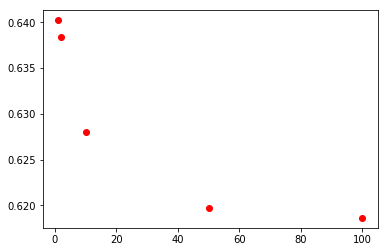

In [72]:
ErmsArr = []
AccuracyArr = []
for i in M :
    # We are using the K means clustering algorithm to cluster the data.
    # Here we are having 10 radial basis function, which means 10 clusters will be formed.
    kmeans = KMeans(n_clusters=i, random_state=0).fit(np.transpose(TrainingData))
    # We have to select one representative from each cluster.
    # we are choosing the center of each cluster to be the representative.
    # This is also known as the feature points.
    Mu = kmeans.cluster_centers_

    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget, (C_Lambda)) 
    #Before Calculating Validation/Testing error, we need to create validation/Testing Design matrix.
    # We cannot use the same Training Data design matrix.
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
    print(Mu.shape)
    print(BigSigma.shape)
    print(TRAINING_PHI.shape)
    print(W.shape)
    print(VAL_PHI.shape)
    print(TEST_PHI.shape)
    
    # used to get the predicted values for trainig, testing and validation datasets
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

     # used to get the Erms values for trainig, testing and validation datasets
    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

    print ('UBITname      = vviswana')
    print ('Person Number = 50290589')
    print ('----------------------------------------------------')
    print ("------------------LeToR Data------------------------")
    print ('----------------------------------------------------')
    print ("-------Closed Form with Radial Basis Function-------")
    print ('----------------------------------------------------')
    print ("M = 10 \nLambda = 0.9")
    print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
    print ("Accuracy Training   = " + str(float(TrainingAccuracy.split(',')[0])))
    print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
    print ("Accuracy Validation = " + str(float(ValidationAccuracy.split(',')[0])))
    print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
    print ("Accuracy Testing    = " + str(float(TestAccuracy.split(',')[0])))
    ErmsArr.append(float(TestAccuracy.split(',')[1]))
    AccuracyArr.append(float(TestAccuracy.split(',')[0]))

plt.plot(M, ErmsArr, 'ro')
plt.show()



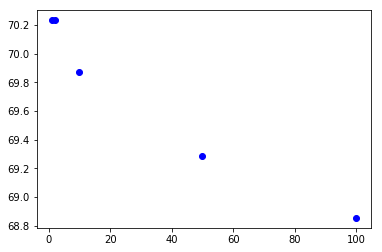

In [73]:
plt.plot(M,AccuracyArr,'bo')
plt.show()

## Finding Erms on training, validation and test set 

## Gradient Descent solution for Linear Regression

In [74]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [75]:
# The w* obtained from previous method is multiplied with 220 a scalar value
# This is because SGD  first takes a random initial value w(0)
W_Now        = np.dot(1, W)
# La is the lambda which as stated earlier is used as a regularizer in order to prevent overfitting
La           = 2 
learningRate = [0.001,0.01,0.05,0.1,0.15]
# Learning rate in SGD must not be too high as it might never converge or if it is too low it will take lot of time to converge
L_Erms_Val   = []
L_Erms_TR    = []

L_Erms_final = []

for j in learningRate : 
    L_Erms_Test  = []
    for i in range(0,400):
        
        # Number of data considered in the entire dataset
        # The next 4 steps are based on the formula where we calculate the weights based on previous iteration.
        # They are used to adjust the weights based on previous value.
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(j,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next # W_Now will be the updated weight now

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
        
    L_Erms_final.append(min(L_Erms_Test))  

print ('----------Gradient Descent Solution--------------------')
print ("M = 10 \nLambda  = 0.0001\neta=0.01")
print ("Accuracy Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("Accuracy Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("Accuracy Testing    = " + str(np.around(min(L_Erms_Test),5)))
 



----------Gradient Descent Solution--------------------
M = 10 
Lambda  = 0.0001
eta=0.01
Accuracy Training   = 0.56279
Accuracy Validation = 0.55091
Accuracy Testing    = 0.63548


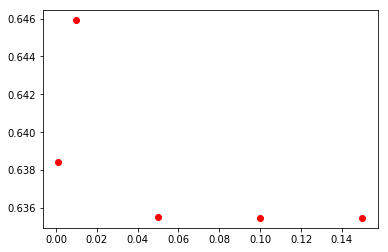

In [76]:
plt.plot(learningRate, L_Erms_final, 'ro')
plt.show()